In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pickleslicer

import jaqalpaq
from jaqalpaq.parser import parse_jaqal_file
from jaqalpaq.emulator import run_jaqal_circuit

mpl.rcParams['font.size'] = 12
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['mathtext.fontset'] = 'cm'

In [2]:
# default approximation of RAV error
ϵ_default = 0.04

def std_f_rav(K, N, λ, ϵ=ϵ_default):
    variance = (1/K) * (N / (N*(1-ϵ)-1))**2 * ((1-λ)*(1-ϵ) + λ/N) * (1 - (1-λ)*(1-ϵ) - λ/N)
    return np.sqrt(variance)

def std_f_xeb(K, N, λ, p2_sum=None, p3_sum=None, p4_sum=None):
    if p2_sum is None:
        p2_sum = (1/2) # * (1 - np.exp(-2*N)) / (1 - np.exp(-N))
    if p3_sum is None:
        p3_sum = (1/3) # * (1 - np.exp(-3*N)) / (1 - np.exp(-N))
    if p4_sum is None:
        p4_sum = (1/4) # * (1 - np.exp(-4*N)) / (1 - np.exp(-N))
    variance = (1/K) * (N/(p2_sum*N-1))**2 * (p2_sum*(λ/N - (λ/N)**2) + p3_sum*(1-λ)*(1-2*λ/N) - p4_sum*(1-λ)**2)
    return np.sqrt(variance)

In [3]:
result_folders = {
    2: 'data/20220417_131316',
    3: 'data/20220417_113750',
    4: 'data/20220417_120122',
    5: 'data/20220417_120127',
    6: 'data/20220418_094437',
    7: 'data/20220418_111618',
    8: 'data/20220420_072324',
}

mixed_state_fraction_list = {}
n_shots_list = {}
rav_x_data = {}
rav_y_data = {}
rav_std_data = {}
xeb_x_data = {}
xeb_y_data = {}
xeb_std_data = {}

rav_success_probs = {}
xeb_success_probs = {}

for n in result_folders:
    load_data = pickleslicer.load(f'{result_folders[n]}/ideal_rav_vs_xeb_simulations_{n}q.pickle')
    
    mixed_state_fraction_list[n] = load_data["mixed_state_fraction_list"]
    n_shots_list[n] = load_data["n_shots_list"]
    rav_x_data[n] = load_data["rav_x_data"]
    rav_y_data[n] = load_data["rav_y_data"]    
    try:
        rav_std_data[n] = load_data["rav_std_data"]
    except:
        rav_x_data[n] = {0: rav_x_data[n]}
        rav_y_data[n] = {0: rav_y_data[n]}
        rav_std_data[n] = {0: {}}
        for i, mixed_state_fraction in enumerate(mixed_state_fraction_list[n]):
            rav_std_data[n][0][mixed_state_fraction] = []    
            for n_shots in n_shots_list[n]:
                current_slice = np.array(rav_x_data[n][0][mixed_state_fraction]) == n_shots
                y_vals = np.extract(current_slice, rav_y_data[n][0][mixed_state_fraction])
                rav_std_data[n][0][mixed_state_fraction].append(np.std(y_vals))
                
    xeb_x_data[n] = load_data["xeb_x_data"]
    xeb_y_data[n] = load_data["xeb_y_data"]
    try:
        xeb_std_data[n] = load_data["xeb_std_data"]
    except:
        xeb_x_data[n] = {0: xeb_x_data[n]}
        xeb_y_data[n] = {0: xeb_y_data[n]}
        xeb_std_data[n] = {0: {}}
        for i, mixed_state_fraction in enumerate(mixed_state_fraction_list[n]):
            xeb_std_data[n][0][mixed_state_fraction] = []    
            for n_shots in n_shots_list[n]:
                current_slice = np.array(xeb_x_data[n][0][mixed_state_fraction]) == n_shots
                y_vals = np.extract(current_slice, xeb_y_data[n][0][mixed_state_fraction])
                xeb_std_data[n][0][mixed_state_fraction].append(np.std(y_vals))

    rav_jaqal_files = [f'{result_folders[n]}/{f}' for f in os.listdir(result_folders[n]) if f'rav_{n}q' in f]
    xeb_jaqal_files = [f'{result_folders[n]}/{f}' for f in os.listdir(result_folders[n]) if f'xeb_{n}q' in f]
    
    rav_success_probs[n] = {}
    for seq_idx, rav_jaqal_file in enumerate(rav_jaqal_files):
        rav_circuit_results = run_jaqal_circuit(parse_jaqal_file(rav_jaqal_file))
        rav_success_probs[n][seq_idx] = rav_circuit_results.subcircuits[0].probability_by_int
        
    xeb_success_probs[n] = {}
    for seq_idx, xeb_jaqal_file in enumerate(xeb_jaqal_files):
        xeb_circuit_results = run_jaqal_circuit(parse_jaqal_file(xeb_jaqal_file))    
        xeb_success_probs[n][seq_idx] = xeb_circuit_results.subcircuits[0].probability_by_int

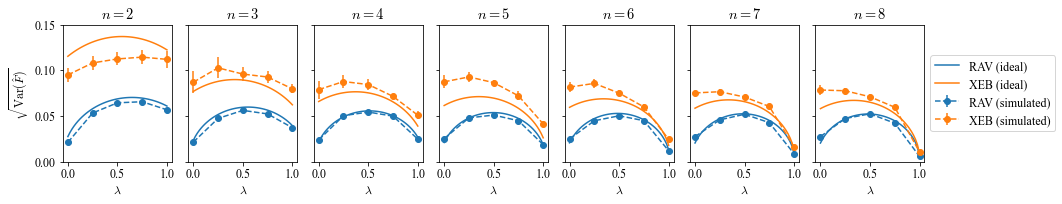

In [4]:
x_data = list(result_folders.keys())

n_shots = 100
y_max = 0.15

n_qubits_list = list(result_folders.keys()) # [2, 3, 4, 5, 6, 7, 8]
x = list(mixed_state_fraction_list[x_data[0]])

fig, ax = plt.subplots(1,len(n_qubits_list),figsize=(15, 3))

for i, n in enumerate(n_qubits_list):
    #
    # plot simulated data as dashed line
    #
    n_shots_idx = np.where(np.array(n_shots_list[x_data[0]]) == n_shots)[0][0]
    y_raw_data_rav = [[rav_std_data[n][seq_idx][mixed_state_fraction][n_shots_idx] for seq_idx in rav_std_data[n]] for mixed_state_fraction in x]
    y_raw_data_xeb = [[xeb_std_data[n][seq_idx][mixed_state_fraction][n_shots_idx] for seq_idx in xeb_std_data[n]] for mixed_state_fraction in x]

    ax[i].errorbar(
        x,
        y=[np.mean(y_raw_data_rav[i]) for i in range(len(x))],
        yerr=[np.std(y_raw_data_rav[i]) / np.sqrt(len(y_raw_data_rav[i])) for i in range(len(x))],
        marker='o', linestyle='--', label='RAV (simulated)', color='C0')
    ax[i].errorbar(
        x,
        y=[np.mean(y_raw_data_xeb[i]) for i in range(len(x))],
        yerr=[np.std(y_raw_data_xeb[i]) / np.sqrt(len(y_raw_data_xeb[i])) for i in range(len(x))],
        marker='o', linestyle='--', label='XEB (simulated)', color='C1')
                
    #
    # plot theoretical calculations as x's
    #        
    rav_p = [rav_success_probs[n][seq_idx][0] for seq_idx in rav_success_probs[n]]
    xeb_sum_p2 = [np.sum(np.array(xeb_success_probs[n][seq_idx])**2) for seq_idx in xeb_success_probs[n]]
    xeb_sum_p3 = [np.sum(np.array(xeb_success_probs[n][seq_idx])**3) for seq_idx in xeb_success_probs[n]]
    xeb_sum_p4 = [np.sum(np.array(xeb_success_probs[n][seq_idx])**4) for seq_idx in xeb_success_probs[n]]

    theory_std_rav = []
    theory_std_xeb = []
    for λ in x:
        N = 2**n
        K = n_shots

        theory_std_rav.append([std_f_rav(K, N, λ, 1-rav_p[seq_idx]) for seq_idx in range(len(rav_p))])
        theory_std_xeb.append([std_f_xeb(K, N, λ, xeb_sum_p2[seq_idx], xeb_sum_p3[seq_idx], xeb_sum_p4[seq_idx])
                              for seq_idx in range(len(xeb_sum_p2))])
    
    #
    # plot theory as solid line
    #
    K = n_shots
    N = 2**n
    λ = np.linspace(min(x), max(x))
    relative_std_rav = std_f_rav(K, N, λ)
    relative_std_xeb = std_f_xeb(K, N, λ)

    ax[i].plot(λ, relative_std_rav, '-', label='RAV (ideal)', color='C0')
    ax[i].plot(λ, relative_std_xeb, '-', label='XEB (ideal)', color='C1')

    ax[i].set_xlabel(r'$\lambda$')
    if i==0:
        ax[i].set_ylabel(r'$\sqrt{{\rm Var}(\hat{F})}$')
    else:
        ax[i].set_yticklabels([])
    ax[i].set_ylim(0, y_max)
    ax[i].set_title(fr'$n = {n}$')
    if i==len(n_qubits_list)-1:
        ax[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout()
plt.savefig('fig4.pdf', bbox_inches='tight')

plt.show()